In [63]:
# filter all the warnings
import warnings
warnings.filterwarnings("ignore")

# data manipulation tools
import pandas as pd
import pandas
import numpy as np

# modeling tools
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb
from optuna import Trial
from sklearn.metrics import f1_score
import torch
from pytorch_tabnet.tab_model import TabNetClassifier
# from torchvision import transforms
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

# plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as pyo
pyo.init_notebook_mode()

# model metrics
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# data preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter

# hyperparameter tuning
import optuna

# model interpretation
import shap
shap.initjs()

# miscellaneous
from pprint import pprint
from joblib import dump
from tqdm import tqdm
from typing import Union, Callable, Tuple, List
import os

In [64]:
data = pd.read_csv('encoded_data.csv')
data

Unnamed: 0   Age  Clarity  Color  Transparency  Spec Gravity  pH Level  \
0             0  23.0        1      3             0         1.005       5.0   
1             1  44.0        0      3             2         1.020       6.0   
2             2  22.0        0      4             1         1.025       6.0   
3             3  16.0        0      4             1         1.020       5.0   
4             4  18.0        0      2             1         1.005       6.5   
..          ...   ...      ...    ...           ...           ...       ...   
107         107  11.0        0      3             1         1.015       6.5   
108         108  50.0        0      3             1         1.010       6.0   
109         109  27.0        0      3             1         1.015       5.0   
110         110  36.0        0      3             1         1.015       5.0   
111         111  33.0        0      2             1         1.005       5.0   

     Leukocytes  Nitrite  Protein  ...  RBC  WBC  Mucus Threads  \
0             0        0        0  ...    0    0              1   
1             0        0        0  ...    3    0              3   
2             0        0        2  ...    0    0              1   
3             0        0        0  ...    0    0              2   
4             0        0        0  ...    0    0              1   
..          ...      ...      ...  ...  ...  ...            ...   
107           0        0        1  ...    2    0              1   
108           0        0        0  ...    0    0              1   
109           1        0        0  ...    0    1              1   
110           1        0        0  ...    3    1              1   
111           0        0        0  ...    0   -1              1   

     Amorphous Urate/Phosphate  DIAGNOSIS  Ethnicity_FILIPINO  \
0                           -1          0                True   
1                            0          0                True   
2                            1          0                True   
3                            0          0                True   
4                            0          0                True   
..                         ...        ...                 ...   
107                          2          0                True   
108                          0          0                True   
109                          1          1                True   
110                          1          1                True   
111                          0          0                True   

     Marital Status_MARRIED  Marital Status_SINGLE  Marital Status_WIDOW  \
0                     False                   True                 False   
1                      True                  False                 False   
2                     False                   True                 False   
3                     False                   True                 False   
4                     False                   True                 False   
..                      ...                    ...                   ...   
107                   False                   True                 False   
108                    True                  False                 False   
109                   False                   True                 False   
110                    True                  False                 False   
111                   False                   True                 False   

     FEMALE  
0      True  
1      True  
2      True  
3      True  
4     False  
..      ...  
107   False  
108   False  
109    True  
110    True  
111    True  

[112 rows x 27 columns]

In [65]:
X = data.drop(columns=['DIAGNOSIS', 'Unnamed: 0'])  
y = data['DIAGNOSIS']

In [66]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)


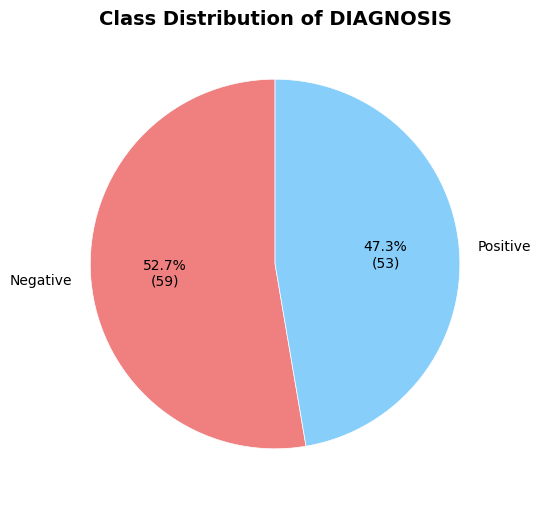

In [68]:
class_counts = y.value_counts()
labels = ['Negative', 'Positive']

def autopct_format(values):
    def inner_autopct(pct):
        total = sum(values)
        count = int(round(pct * total / 100.0))
        return f'{pct:.1f}%\n({count:d})'
    return inner_autopct

plt.figure(figsize=(6, 6))
plt.pie(class_counts, labels=labels, autopct=autopct_format(class_counts), startangle=90, 
        colors=['lightcoral', 'lightskyblue'], wedgeprops={'linewidth': 0.5, 'edgecolor': 'white'})

plt.title('Class Distribution of DIAGNOSIS', fontsize=14, fontweight='bold')

plt.show()

In [69]:
X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(X_train, 
                                                                    y_train, 
                                                                    test_size=0.2,
                                                                    random_state=42,
                                                                   stratify = y_train)

In [70]:
def show_study_summary(study: optuna.study.Study) -> None:
    print("\033[1mBest Hyperparameters")
    pprint(study.best_params)
    print()

    print("\033[1mAccuracy for the Best Hyperparameters")
    print(study.best_value)

    optimization_history_plot = optuna.visualization.plot_optimization_history(study)
    param_importances_plot = optuna.visualization.plot_param_importances(study)


    optimization_history_plot.update_layout({"height": 600})
    param_importances_plot.update_layout({"height": 600})


    optimization_history_plot.show()
    param_importances_plot.show()


## Logistic Regression

In [71]:
def logreg_objective(trial: optuna.study.Study) -> float:
    PARAMS = {
        "tol": trial.suggest_float("tol", 1e-6, 1e-2, log=True),
        "C": trial.suggest_float("C", 0.1, 1)
    }

    LOGREG = LogisticRegression(**PARAMS, max_iter=2000, random_state=42)

    LOGREG.fit(X_train_val, y_train_val)

    THRESHOLD = trial.suggest_float('threshold', 0.1, 1)

    YHAT = [1 if proba[1] > THRESHOLD else 0 for proba in LOGREG.predict_proba(X_test_val)]

    F1_SCORE_ = f1_score(y_test_val, YHAT)

    return F1_SCORE_

SEED = 42  
SAMPLER = optuna.samplers.TPESampler(seed=SEED)


LOGREG_STUDY = optuna.create_study(direction="maximize", study_name="logreg_tuning", sampler=SAMPLER)

LOGREG_STUDY.optimize(logreg_objective, n_trials=200, n_jobs=-1, show_progress_bar=True)

[I 2024-10-31 23:37:09,432] A new study created in memory with name: logreg_tuning


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2024-10-31 23:37:09,553] Trial 0 finished with value: 0.7777777777777778 and parameters: {'tol': 7.458315299974836e-05, 'C': 0.5316844881827895, 'threshold': 0.5349354138646176}. Best is trial 0 with value: 0.7777777777777778.
[I 2024-10-31 23:37:09,571] Trial 1 finished with value: 0.9 and parameters: {'tol': 0.00014876295151210973, 'C': 0.5350192023723288, 'threshold': 0.21643084294629034}. Best is trial 1 with value: 0.9.
[I 2024-10-31 23:37:09,588] Trial 4 finished with value: 0.8235294117647058 and parameters: {'tol': 0.0008241008174825515, 'C': 0.6534930471024324, 'threshold': 0.7098753462201108}. Best is trial 1 with value: 0.9.
[I 2024-10-31 23:37:09,603] Trial 5 finished with value: 0.8235294117647058 and parameters: {'tol': 0.007547097778454665, 'C': 0.35592057556222045, 'threshold': 0.6473018673689415}. Best is trial 1 with value: 0.9.
[I 2024-10-31 23:37:09,613] Trial 2 finished with value: 0.8421052631578947 and parameters: {'tol': 0.0008288327987335128, 'C': 0.72920416

In [72]:
show_study_summary(LOGREG_STUDY)

Best Hyperparameters
{'C': 0.30473420340478935,
 'threshold': 0.16695243596279313,
 'tol': 1.328651337384057e-05}

Accuracy for the Best Hyperparameters
0.9523809523809523


## Support Vector Machine

In [73]:
def SVC_objective(trial: optuna.study.Study) -> float:
    PARAMS = {
        "C": trial.suggest_float("C", 0.1, 10, log=True),
        "kernel": trial.suggest_categorical("kernel", ["linear", "poly", "rbf", "sigmoid"])
    }

    SVC_MODEL = SVC(**PARAMS, probability=True, random_state=42)

    SVC_MODEL.fit(X_train_val, y_train_val)

    YHAT = SVC_MODEL.predict(X_test_val)

    F1_SCORE_ = f1_score(y_test_val, YHAT)

    return F1_SCORE_

SEED = 42  
SAMPLER = optuna.samplers.TPESampler(seed=SEED)

SVM_SVC_STUDY = optuna.create_study(direction="maximize", study_name="SVM_tuning", sampler=SAMPLER)

SVM_SVC_STUDY.optimize(SVC_objective, n_trials=200, n_jobs=-1, show_progress_bar=True)

[I 2024-10-31 23:37:23,373] A new study created in memory with name: SVM_tuning


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2024-10-31 23:37:23,407] Trial 0 finished with value: 0.7777777777777778 and parameters: {'C': 3.5211687290387843, 'kernel': 'linear'}. Best is trial 0 with value: 0.7777777777777778.
[I 2024-10-31 23:37:23,432] Trial 1 finished with value: 0.8888888888888888 and parameters: {'C': 0.38110590512625203, 'kernel': 'sigmoid'}. Best is trial 1 with value: 0.8888888888888888.
[I 2024-10-31 23:37:23,473] Trial 3 finished with value: 0.8421052631578947 and parameters: {'C': 3.833523920392335, 'kernel': 'sigmoid'}. Best is trial 1 with value: 0.8888888888888888.
[I 2024-10-31 23:37:23,473] Trial 4 finished with value: 0.8235294117647058 and parameters: {'C': 1.9844824812995399, 'kernel': 'poly'}. Best is trial 1 with value: 0.8888888888888888.
[I 2024-10-31 23:37:23,482] Trial 7 finished with value: 0.7777777777777778 and parameters: {'C': 8.174021897267341, 'kernel': 'linear'}. Best is trial 1 with value: 0.8888888888888888.
[I 2024-10-31 23:37:23,490] Trial 6 finished with value: 0.4615384

In [74]:
show_study_summary(SVM_SVC_STUDY)

Best Hyperparameters
{'C': 0.38110590512625203, 'kernel': 'sigmoid'}

Accuracy for the Best Hyperparameters
0.8888888888888888


## XGBoost


In [75]:
def XGB_objective(trial: optuna.study.Study) -> float:

    PARAMS = {
        "objective": "binary:logistic",
        "booster": "gbtree",
        "reg_alpha": trial.suggest_float("reg_alpha", 0.1, 0.9),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=50),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "learning_rate": trial.suggest_float("learning_rate", 0.0001, 0.1, log=True)
    }

    XGB_model = xgb.XGBClassifier(**PARAMS, random_state=42)

    XGB_model.fit(X_train_val, y_train_val)

    YHAT = XGB_model.predict(X_test_val)

    F1_SCORE_ = f1_score(y_test_val, YHAT)

    return F1_SCORE_

SEED = 42  
SAMPLER = optuna.samplers.TPESampler(seed=SEED)

XGB_STUDY = optuna.create_study(direction="maximize", study_name="XGB_tuning", sampler=SAMPLER)

XGB_STUDY.optimize(XGB_objective, n_trials=200, n_jobs=-1, show_progress_bar=True)

[I 2024-10-31 23:37:31,890] A new study created in memory with name: XGB_tuning


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2024-10-31 23:37:33,248] Trial 6 finished with value: 0.9523809523809523 and parameters: {'reg_alpha': 0.8573285434912763, 'n_estimators': 200, 'max_depth': 11, 'learning_rate': 0.004557008532238421}. Best is trial 6 with value: 0.9523809523809523.
[I 2024-10-31 23:37:33,441] Trial 3 finished with value: 0.9473684210526315 and parameters: {'reg_alpha': 0.3187933921283097, 'n_estimators': 250, 'max_depth': 9, 'learning_rate': 0.002008778164699193}. Best is trial 6 with value: 0.9523809523809523.
[I 2024-10-31 23:37:34,855] Trial 0 finished with value: 0.8421052631578947 and parameters: {'reg_alpha': 0.7184342076897855, 'n_estimators': 750, 'max_depth': 12, 'learning_rate': 0.05591754160128685}. Best is trial 6 with value: 0.9523809523809523.
[I 2024-10-31 23:37:35,210] Trial 1 finished with value: 0.9473684210526315 and parameters: {'reg_alpha': 0.3119333379446728, 'n_estimators': 550, 'max_depth': 8, 'learning_rate': 0.0010239152312563457}. Best is trial 6 with value: 0.952380952380

In [76]:
show_study_summary(XGB_STUDY)

Best Hyperparameters
{'learning_rate': 0.004557008532238421,
 'max_depth': 11,
 'n_estimators': 200,
 'reg_alpha': 0.8573285434912763}

Accuracy for the Best Hyperparameters
0.9523809523809523


## LGBM

In [77]:
def lightgbm_objective(trial: optuna.study.Study) -> float:

    PARAMS = {
        "data_sample_strategy": "goss",
        "verbosity": -1,
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart"]),
        "num_leaves": trial.suggest_int('num_leaves', 10, 200, step=10),
        "n_estimators": trial.suggest_int("n_estimators", 100, 500, step=50),
        "max_depth": trial.suggest_categorical("max_depth", [-1, 3, 4, 5]),
        "learning_rate": trial.suggest_float("learning_rate", 0.0001, 0.1, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.1, 0.9)
    }
    
    LGMB_MODEL = lgb.LGBMClassifier(**PARAMS, random_state=42)
    
    LGMB_MODEL.fit(X_train_val, y_train_val) 
    
    YHAT = LGMB_MODEL.predict(X_test_val)
    
    F1_SCORE_ = f1_score(y_test_val, YHAT)
    
    return F1_SCORE_

SEED = 42  
SAMPLER = optuna.samplers.TPESampler(seed=SEED)

LGBM_STUDY = optuna.create_study(direction="maximize", study_name="lgbm_tuning", sampler=SAMPLER)

LGBM_STUDY.optimize(lightgbm_objective, n_trials=200, n_jobs=-1, show_progress_bar=True)

[I 2024-10-31 23:38:15,393] A new study created in memory with name: lgbm_tuning


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2024-10-31 23:38:15,509] Trial 1 finished with value: 0.8888888888888888 and parameters: {'boosting_type': 'dart', 'num_leaves': 30, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.025390556336259026, 'reg_alpha': 0.6850618299156982}. Best is trial 1 with value: 0.8888888888888888.
[I 2024-10-31 23:38:15,555] Trial 2 finished with value: 0.7142857142857143 and parameters: {'boosting_type': 'dart', 'num_leaves': 20, 'n_estimators': 250, 'max_depth': -1, 'learning_rate': 0.060197288362754196, 'reg_alpha': 0.1614235045754512}. Best is trial 1 with value: 0.8888888888888888.
[I 2024-10-31 23:38:15,585] Trial 5 finished with value: 0.7142857142857143 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 180, 'n_estimators': 250, 'max_depth': 3, 'learning_rate': 0.00015313989617108382, 'reg_alpha': 0.3499539814379958}. Best is trial 1 with value: 0.8888888888888888.
[I 2024-10-31 23:38:15,634] Trial 3 finished with value: 0.8888888888888888 and parameters: {'boosting_type': 'gbd

In [78]:
show_study_summary(LGBM_STUDY)

Best Hyperparameters
{'boosting_type': 'dart',
 'learning_rate': 0.025390556336259026,
 'max_depth': 5,
 'n_estimators': 150,
 'num_leaves': 30,
 'reg_alpha': 0.6850618299156982}

Accuracy for the Best Hyperparameters
0.8888888888888888


## TabNet

In [79]:
def tabnet_objective(trial: optuna.study.Study) -> float:

    PARAMS = {
    "n_d": trial.suggest_int('n_d', 8, 64),  
    "n_a": trial.suggest_int('n_a', 8, 64), 
    "n_steps": trial.suggest_int('n_steps', 3, 10),  
    "gamma": trial.suggest_float('gamma', 1.0, 2.0),  
    "lambda_sparse": trial.suggest_float('lambda_sparse', 1e-5, 1e-3, log=True), 
    "n_independent": trial.suggest_int('n_independent', 1, 5),  
    "n_shared": trial.suggest_int('n_shared', 1, 5)  
    }

    TAB_MODEL = TabNetClassifier(**PARAMS)

    TAB_MODEL.fit(X_train_val, y_train_val,
        max_epochs=50,
        patience=15,  
        batch_size=1024,
        virtual_batch_size=128)

    YHAT = TAB_MODEL.predict(X_test_val)

    F1_SCORE_ = f1_score(y_test_val, YHAT)

    return F1_SCORE_

SEED = 42  
SAMPLER = optuna.samplers.TPESampler(seed=SEED)

TABNET_STUDY = optuna.create_study(direction="maximize", study_name="tabnet_tuning", sampler=SAMPLER)

TABNET_STUDY.optimize(tabnet_objective, n_trials=200, n_jobs=-1, show_progress_bar=True)


[I 2024-10-31 23:38:31,647] A new study created in memory with name: tabnet_tuning


  0%|          | 0/200 [00:00<?, ?it/s]

epoch 0  | loss: 0.0     |  0:00:00s
epoch 1  | loss: 0.0     |  0:00:00s
epoch 2  | loss: 0.0     |  0:00:00s
epoch 3  | loss: 0.0     |  0:00:00s
epoch 0  | loss: 0.0     |  0:00:00s
epoch 4  | loss: 0.0     |  0:00:00s
epoch 5  | loss: 0.0     |  0:00:00s
epoch 1  | loss: 0.0     |  0:00:00s
epoch 2  | loss: 0.0     |  0:00:00s
epoch 6  | loss: 0.0     |  0:00:00s
epoch 7  | loss: 0.0     |  0:00:00s
epoch 3  | loss: 0.0     |  0:00:00s
epoch 4  | loss: 0.0     |  0:00:00s
epoch 8  | loss: 0.0     |  0:00:00s
epoch 9  | loss: 0.0     |  0:00:00s
epoch 5  | loss: 0.0     |  0:00:00s
epoch 6  | loss: 0.0     |  0:00:00s
epoch 10 | loss: 0.0     |  0:00:00s
epoch 7  | loss: 0.0     |  0:00:00s
epoch 11 | loss: 0.0     |  0:00:00s
epoch 8  | loss: 0.0     |  0:00:00s
epoch 12 | loss: 0.0     |  0:00:00s
epoch 9  | loss: 0.0     |  0:00:00s
epoch 10 | loss: 0.0     |  0:00:00s
epoch 13 | loss: 0.0     |  0:00:00s
epoch 11 | loss: 0.0     |  0:00:00s
epoch 12 | loss: 0.0     |  0:00:00s
e

In [80]:
show_study_summary(TABNET_STUDY)

Best Hyperparameters
{'gamma': 1.9335356044339014,
 'lambda_sparse': 1.8190705752640682e-05,
 'n_a': 28,
 'n_d': 19,
 'n_independent': 3,
 'n_shared': 1,
 'n_steps': 8}

Accuracy for the Best Hyperparameters
0.8


In [81]:
def test_model(
        models: list,
        params: dict,
        X_train: Union[np.array, pd.DataFrame],
        y_train: Union[np.array, pd.DataFrame],
        X_test: Union[np.array, pd.DataFrame],
        y_test: Union[np.array, pd.DataFrame]
    ) -> Tuple[Union[dict, pd.DataFrame]]:

    model_testing_scores = pd.DataFrame()
    models_container = {}

    model_testing_scores["Model"] = []
    model_testing_scores["Accuracy"] = []
    model_testing_scores["Precision"] = []
    model_testing_scores["Recall"] = []
    model_testing_scores["F1-Score"] = []
    model_testing_scores["Specificity"] = []
    model_testing_scores["AUC-ROC"] = []

    for model in tqdm(models):
        MODEL_NAME = model().__class__.__name__


        MODEL_KEY = MODEL_NAME + "_R" if (MODEL_NAME + "_R") in params else MODEL_NAME

        if MODEL_KEY == "LogisticRegression_R" or MODEL_KEY == "LogisticRegression":

            test_model = model(tol=params[MODEL_KEY]["tol"],
                               C=params[MODEL_KEY]["C"],
                               max_iter=2000)

            test_model.fit(X_train, y_train)

            test_pred = [1 if proba[1] > params[MODEL_KEY]["threshold"] else 0 for proba in
                         test_model.predict_proba(X_test)]

            TN, FP, _, _ = confusion_matrix(y_test, test_pred).ravel()
            TESTING_SPECIFICITY = TN / (TN + FP)


            model_testing_scores = model_testing_scores._append({"Model": MODEL_KEY,
                                                                "Accuracy": accuracy_score(y_test, test_pred),
                                                                "Precision": precision_score(y_test, test_pred),
                                                                "Recall": recall_score(y_test, test_pred),
                                                                "F1-Score": f1_score(y_test, test_pred),
                                                                "Specificity": TESTING_SPECIFICITY,
                                                                "AUC-ROC": roc_auc_score(y_test, test_pred)},
                                                               ignore_index=True)
        else:
            test_model = model(**params[MODEL_KEY])

            test_model.fit(X_train, y_train)
            test_pred = test_model.predict(X_test)

            TN, FP, _, _ = confusion_matrix(y_test, test_pred).ravel()
            TESTING_SPECIFICITY = TN / (TN + FP)

            model_testing_scores = model_testing_scores._append({"Model": MODEL_KEY,
                                                                "Accuracy": accuracy_score(y_test, test_pred),
                                                                "Precision": precision_score(y_test, test_pred),
                                                                "Recall": recall_score(y_test, test_pred),
                                                                "F1-Score": f1_score(y_test, test_pred),
                                                                "Specificity": TESTING_SPECIFICITY,
                                                                "AUC-ROC": roc_auc_score(y_test, test_pred)},
                                                               ignore_index=True)

        models_container[MODEL_KEY] = test_model

    return models_container, model_testing_scores


In [82]:
LIST_OF_MODELS = [LogisticRegression, SVC, xgb.XGBClassifier, lgb.LGBMClassifier, TabNetClassifier]

MODELS_PARAMETERS = {"LogisticRegression":{'C': 0.630989471773958,
                    'threshold': 0.6528874325091278,
                    'tol': 0.0024110001509029164
},
                     
                    "SVC":{'C': 0.13279341165552225, 'kernel': 'linear'},
                     
                    "XGBClassifier":{'learning_rate': 0.0007722051215058448,
                                    'max_depth': 8,
                                    'n_estimators': 500,
                                    'reg_alpha': 0.2419272474393898
                                    },
                     
                     "LGBMClassifier": {"data_sample_strategy": "goss",
                                        "verbosity": -1, 
                                        'boosting_type': 'dart',
                                        'learning_rate': 0.052778649673377524,
                                        'max_depth': 5,
                                        'n_estimators': 300,
                                        'num_leaves': 180,
                                        'reg_alpha': 0.5614439674607745
                                        },
                    "TabNetClassifier": {'gamma': 1.004684495138199,
                                        'lambda_sparse': 0.0001856114663408579,
                                        'n_a': 54,
                                        'n_d': 16,
                                        'n_independent': 5,
                                        'n_shared': 2,
                                        'n_steps': 8
                                        }
                    }



MODEL_CONTAINER, TESTING_SCORES = test_model(LIST_OF_MODELS, MODELS_PARAMETERS, X_train, y_train, X_test, y_test)

 60%|██████    | 3/5 [00:00<00:00, 19.46it/s]

epoch 0  | loss: 0.0     |  0:00:00s
epoch 1  | loss: 0.0     |  0:00:00s
epoch 2  | loss: 0.0     |  0:00:00s
epoch 3  | loss: 0.0     |  0:00:00s
epoch 4  | loss: 0.0     |  0:00:00s
epoch 5  | loss: 0.0     |  0:00:00s
epoch 6  | loss: 0.0     |  0:00:00s
epoch 7  | loss: 0.0     |  0:00:00s
epoch 8  | loss: 0.0     |  0:00:00s
epoch 9  | loss: 0.0     |  0:00:00s
epoch 10 | loss: 0.0     |  0:00:00s
epoch 11 | loss: 0.0     |  0:00:00s
epoch 12 | loss: 0.0     |  0:00:00s
epoch 13 | loss: 0.0     |  0:00:00s
epoch 14 | loss: 0.0     |  0:00:00s
epoch 15 | loss: 0.0     |  0:00:00s
epoch 16 | loss: 0.0     |  0:00:00s
epoch 17 | loss: 0.0     |  0:00:00s
epoch 18 | loss: 0.0     |  0:00:00s
epoch 19 | loss: 0.0     |  0:00:00s
epoch 20 | loss: 0.0     |  0:00:00s
epoch 21 | loss: 0.0     |  0:00:00s
epoch 22 | loss: 0.0     |  0:00:00s
epoch 23 | loss: 0.0     |  0:00:00s
epoch 24 | loss: 0.0     |  0:00:00s
epoch 25 | loss: 0.0     |  0:00:00s
epoch 26 | loss: 0.0     |  0:00:00s
e

100%|██████████| 5/5 [00:00<00:00, 10.36it/s]


In [83]:
TESTING_SCORES

Model  Accuracy  Precision    Recall  F1-Score  Specificity  \
0  LogisticRegression  0.913043   0.916667  0.916667  0.916667     0.909091   
1                 SVC  0.869565   0.846154  0.916667  0.880000     0.818182   
2       XGBClassifier  0.869565   0.800000  1.000000  0.888889     0.727273   
3      LGBMClassifier  0.521739   0.521739  1.000000  0.685714     0.000000   
4    TabNetClassifier  0.347826   0.421053  0.666667  0.516129     0.000000   

    AUC-ROC  
0  0.912879  
1  0.867424  
2  0.863636  
3  0.500000  
4  0.333333

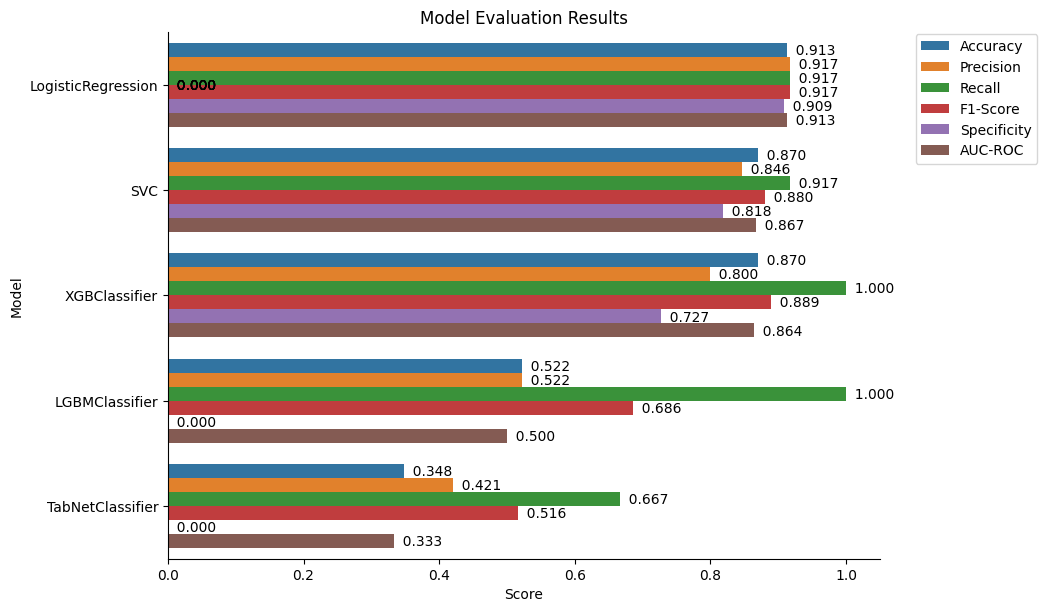

In [84]:
# Prepare data for plotting
plot_df = pd.melt(TESTING_SCORES, id_vars=["Model"])
plot_df.rename({"variable": "Metric", "value": "Score"}, axis=1, inplace=True)

# Create a horizontal bar plot using Seaborn
PLOT = sns.catplot(x="Score", y="Model", hue="Metric", data=plot_df, kind="bar", orient="h",
                   height=6, aspect=1.5, legend_out=False)

# Access the axes of the plot
ax = PLOT.axes[0, 0]

# Annotate the bars with their corresponding scores
for p in ax.patches:
    ax.annotate(f" {p.get_width(): .3f}", (p.get_x() + p.get_width(), (p.get_y() + 0.045) + p.get_height() / 2), ha="left")

# Set plot title, legend, and display the plot
plt.title("Model Evaluation Results")
plt.legend(loc=(1.05, 0.75))
plt.show()

In [85]:
def plot_feature_importances(model, title):
    n_features = X_train_val.shape[1]

    results = {column:value for value, column in zip(model.feature_importances_, X_train_val.columns)}

    sorted_results = {column:value for column, value in sorted(results.items(), key = lambda x: x[1])}

    plt.barh(range(len(sorted_results.values())), sorted_results.values(), align='center', color="lightblue")
    plt.yticks(range(len(sorted_results.values())), sorted_results.keys())

    plt.title(f"{title}: Feature Importance")
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1,n_features)
    plt.show()

In [86]:
TRAINED_XGB = MODEL_CONTAINER["XGBClassifier"]
TRAINED_LGBM = MODEL_CONTAINER["LGBMClassifier"]
TRAINED_SVM = MODEL_CONTAINER["SVC"]
TRAINED_LOGREG = MODEL_CONTAINER["LogisticRegression"]
TRAINED_TABNET = MODEL_CONTAINER["TabNetClassifier"]

## XGB SHAP

In [87]:
XGB_EXPLAINER = shap.TreeExplainer(TRAINED_XGB, X_test)

XGB_SHAP_VALUES = XGB_EXPLAINER.shap_values(X_test, check_additivity=False)

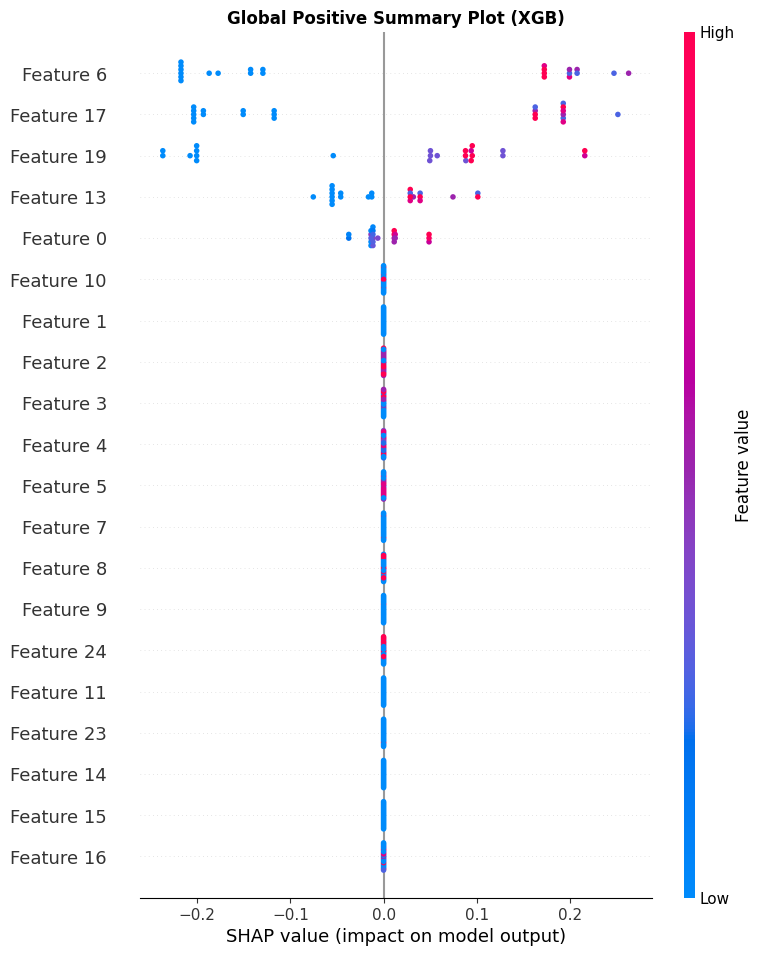

In [88]:
# SHAP Global Positive Summary Plot
shap.summary_plot(XGB_SHAP_VALUES, X_test, show=False)
plt.title("Global Positive Summary Plot (XGB)", fontdict={"fontweight":"bold"})
plt.show()

## LGB SHAP

In [89]:
LGBM_EXPLAINER = shap.TreeExplainer(TRAINED_LGBM, X_test)

LGBM_SHAP_VALUES = LGBM_EXPLAINER.shap_values(X_test, check_additivity=False)

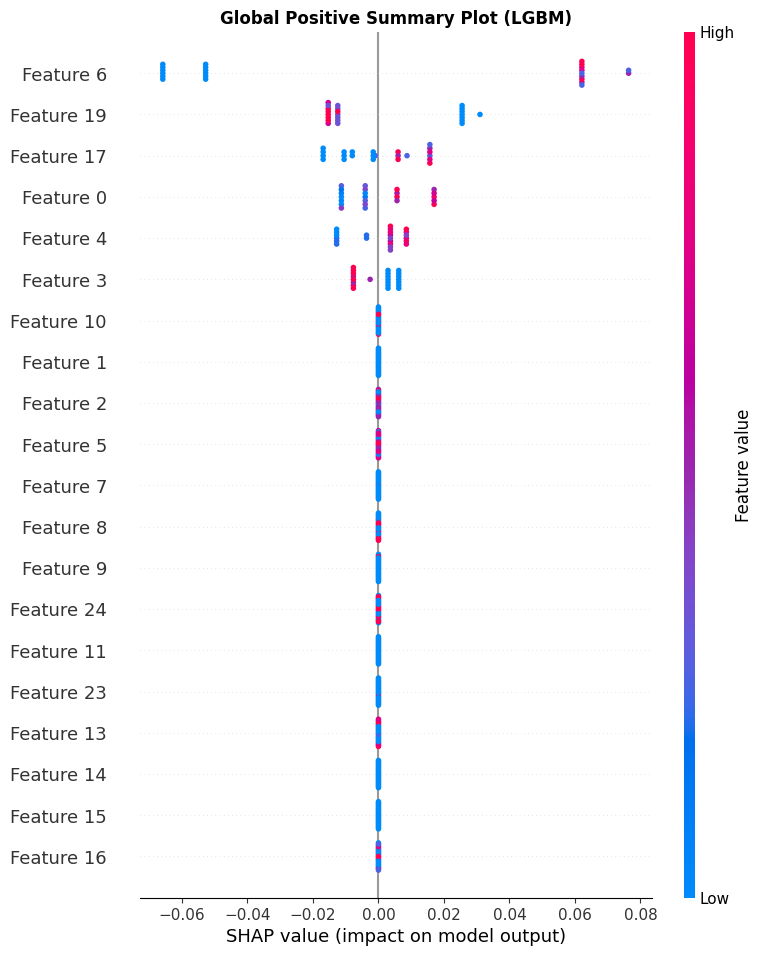

In [90]:
# SHAP Global Positive Summary Plot
shap.summary_plot(LGBM_SHAP_VALUES, X_test, show=False)
plt.title("Global Positive Summary Plot (LGBM)", fontdict={"fontweight":"bold"})
plt.show()

## LOGREG SHAP

In [91]:
LOGREG_EXPLAINER = shap.LinearExplainer(TRAINED_LOGREG, X_test)

LOGREG_SHAP_VALUES = LOGREG_EXPLAINER.shap_values(X_test)

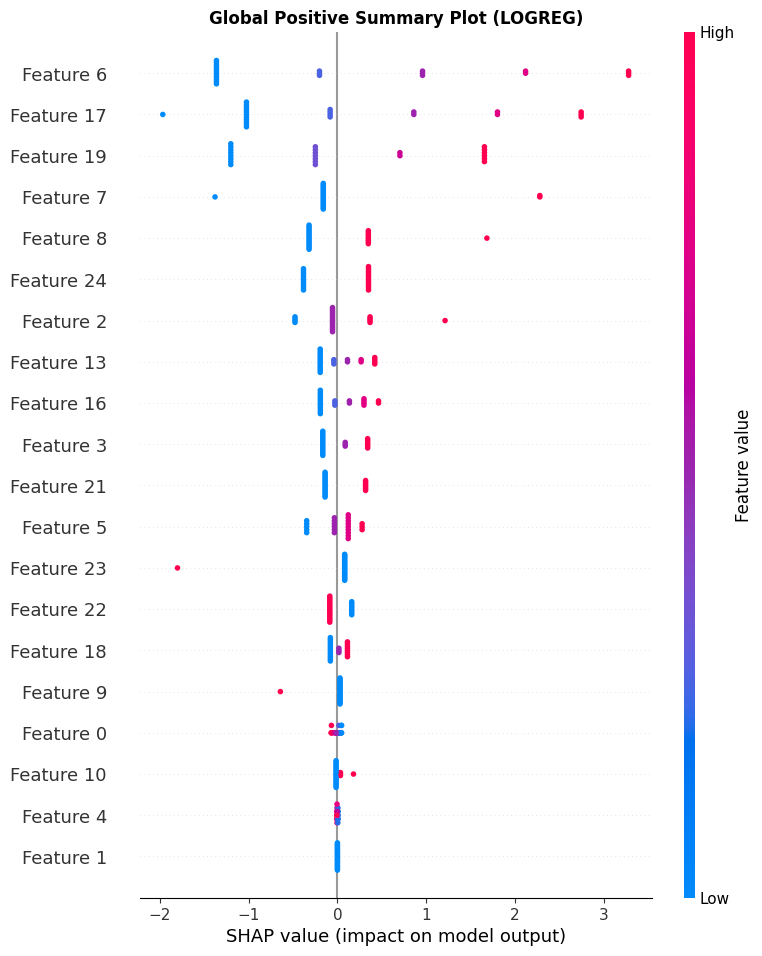

In [92]:
# SHAP Global Positive Summary Plot
shap.summary_plot(LOGREG_SHAP_VALUES, X_test, show=False)
plt.title("Global Positive Summary Plot (LOGREG)", fontdict={"fontweight":"bold"})
plt.show()

## SVM SHAP

In [93]:
SVM_EXPLAINER = shap.LinearExplainer(TRAINED_SVM, X_test)

SVM_SHAP_VALUES = SVM_EXPLAINER.shap_values(X_test)

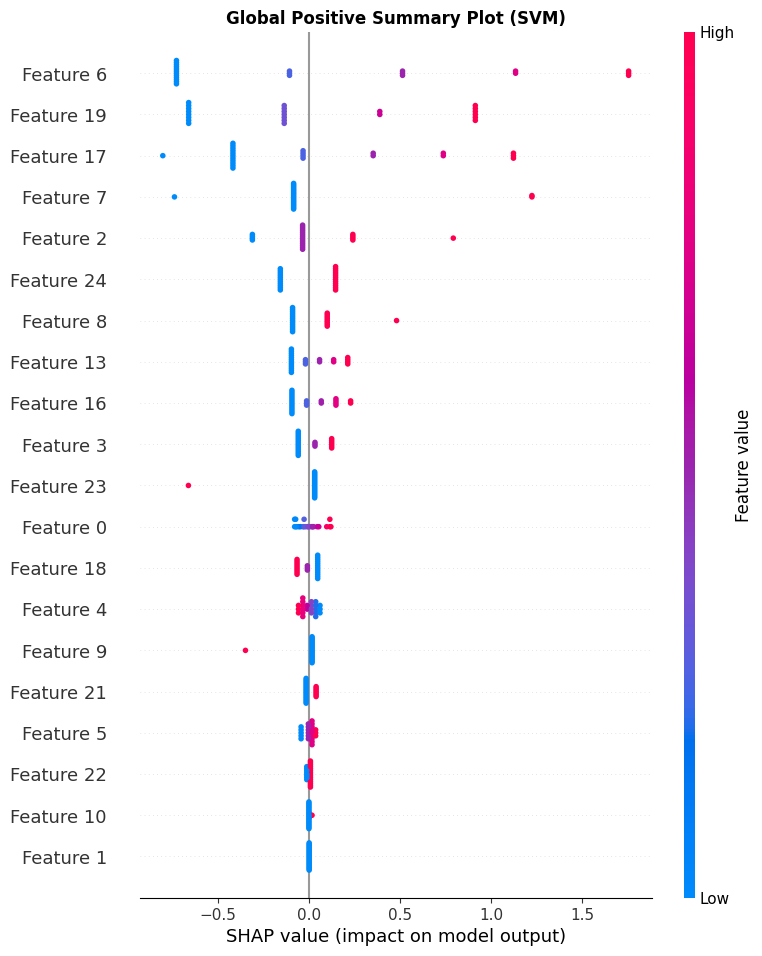

In [94]:
# SHAP Global Positive Summary Plot
shap.summary_plot(SVM_SHAP_VALUES, X_test, show=False)
plt.title("Global Positive Summary Plot (SVM)", fontdict={"fontweight":"bold"})
plt.show()

In [95]:
import pandas as pd

def print_top_shap_features(shap_values, feature_names, model_name="Model", top_n=10):
 
    shap_values_df = pd.DataFrame(shap_values, columns=feature_names)

    shap_values_sum = shap_values_df.abs().mean(axis=0)

    top_features = shap_values_sum.sort_values(ascending=False).head(top_n)

    print(f"\nTop {top_n} Features for {model_name} based on SHAP values:")
    print(top_features.to_frame(name='Mean Absolute SHAP Value'))

    return np.array(top_features.index)


In [96]:
top_features_svm = print_top_shap_features(SVM_SHAP_VALUES, feature_names=X.columns, model_name="SVC", top_n=10)
top_features_svm


Top 10 Features for SVC based on SHAP values:
                           Mean Absolute SHAP Value
Leukocytes                                 0.789207
Amorphous Urate/Phosphate                  0.544005
WBC                                        0.482345
Nitrite                                    0.212934
Color                                      0.152381
FEMALE                                     0.151567
Protein                                    0.110906
Blood                                      0.107128
RBC                                        0.102423
Transparency                               0.072879


array(['Leukocytes', 'Amorphous Urate/Phosphate', 'WBC', 'Nitrite',
       'Color', 'FEMALE', 'Protein', 'Blood', 'RBC', 'Transparency'],
      dtype=object)

In [97]:
top_features_lgbm = print_top_shap_features(LGBM_SHAP_VALUES, feature_names=X.columns, model_name="LGBMClassifier", top_n=10)
top_features_lgbm


Top 10 Features for LGBMClassifier based on SHAP values:
                           Mean Absolute SHAP Value
Leukocytes                                 0.061894
Amorphous Urate/Phosphate                  0.018240
WBC                                        0.010508
Age                                        0.009357
Spec Gravity                               0.007298
Transparency                               0.005546
Bacteria                                   0.000000
Marital Status_WIDOW                       0.000000
Marital Status_SINGLE                      0.000000
Marital Status_MARRIED                     0.000000


array(['Leukocytes', 'Amorphous Urate/Phosphate', 'WBC', 'Age',
       'Spec Gravity', 'Transparency', 'Bacteria', 'Marital Status_WIDOW',
       'Marital Status_SINGLE', 'Marital Status_MARRIED'], dtype=object)

In [98]:
top_features_xgb = print_top_shap_features(XGB_SHAP_VALUES, feature_names=X.columns, model_name="XGBClassifier", top_n=10)
top_features_xgb


Top 10 Features for XGBClassifier based on SHAP values:
                           Mean Absolute SHAP Value
Leukocytes                                 0.192503
WBC                                        0.179057
Amorphous Urate/Phosphate                  0.133733
Blood                                      0.047012
Age                                        0.018861
Marital Status_WIDOW                       0.000000
Marital Status_SINGLE                      0.000000
Marital Status_MARRIED                     0.000000
Ethnicity_FILIPINO                         0.000000
Mucus Threads                              0.000000


array(['Leukocytes', 'WBC', 'Amorphous Urate/Phosphate', 'Blood', 'Age',
       'Marital Status_WIDOW', 'Marital Status_SINGLE',
       'Marital Status_MARRIED', 'Ethnicity_FILIPINO', 'Mucus Threads'],
      dtype=object)

In [99]:
top_features_logreg = print_top_shap_features(LOGREG_SHAP_VALUES, feature_names=X.columns, model_name="LogisitcRegression", top_n=10)


Top 10 Features for LogisitcRegression based on SHAP values:
                           Mean Absolute SHAP Value
Leukocytes                                 1.472649
WBC                                        1.177966
Amorphous Urate/Phosphate                  0.985384
Nitrite                                    0.396001
Protein                                    0.388281
FEMALE                                     0.364971
Color                                      0.233014
Blood                                      0.212351
RBC                                        0.207878
Transparency                               0.200449


In [100]:
top_features_logreg = top_features_logreg.tolist()
top_features_logreg

['Leukocytes',
 'WBC',
 'Amorphous Urate/Phosphate',
 'Nitrite',
 'Protein',
 'FEMALE',
 'Color',
 'Blood',
 'RBC',
 'Transparency']

# REDUCED MODELS


In [101]:
all_features = X.columns.tolist()  

print(all_features)  


['Age', 'Clarity', 'Color', 'Transparency', 'Spec Gravity', 'pH Level', 'Leukocytes', 'Nitrite', 'Protein', 'Glucose', 'Ketones', 'Urobilinogen', 'Bilirubin', 'Blood', 'Bacteria', 'Epithelial Cells', 'RBC', 'WBC', 'Mucus Threads', 'Amorphous Urate/Phosphate', 'Ethnicity_FILIPINO', 'Marital Status_MARRIED', 'Marital Status_SINGLE', 'Marital Status_WIDOW', 'FEMALE']


In [102]:
# Convert the top feature names to their corresponding indices in the original feature list
top_feature_indices_logreg = [all_features.index(feature) for feature in top_features_logreg]
top_feature_indices_lgbm = [all_features.index(feature) for feature in top_features_lgbm]
top_feature_indices_xgb = [all_features.index(feature) for feature in top_features_xgb]
top_feature_indices_svm = [all_features.index(feature) for feature in top_features_svm]

X_train_logreg = X_train[:, top_feature_indices_logreg]
X_test_logreg = X_test[:, top_feature_indices_logreg]

X_train_lgbm = X_train[:, top_feature_indices_lgbm]
X_test_lgbm = X_test[:, top_feature_indices_lgbm]

X_train_xgb = X_train[:, top_feature_indices_xgb]
X_test_xgb = X_test[:, top_feature_indices_xgb]

X_train_svm = X_train[:, top_feature_indices_svm]
X_test_svm = X_test[:, top_feature_indices_svm]

X_train_val_logreg = X_train_val[:, top_feature_indices_logreg]
X_test_val_logreg = X_test_val[:, top_feature_indices_logreg]

X_train_val_lgbm = X_train_val[:, top_feature_indices_lgbm]
X_test_val_lgbm = X_test_val[:, top_feature_indices_lgbm]

X_train_val_xgb = X_train_val[:, top_feature_indices_xgb]
X_test_val_xgb = X_test_val[:, top_feature_indices_xgb]

X_train_val_svm = X_train_val[:, top_feature_indices_svm]
X_test_val_svm = X_test_val[:, top_feature_indices_svm]


## Reduced Logistic Regression Optuna

In [103]:
def logreg_objective_r(trial: optuna.study.Study) -> float:
    PARAMS = {
        "tol": trial.suggest_float("tol", 1e-6, 1e-2, log=True),
        "C": trial.suggest_float("C", 0.1, 1)
    }

    LOGREG_R = LogisticRegression(**PARAMS, max_iter=2000, random_state=42)

    LOGREG_R.fit(X_train_val_logreg, y_train_val)

    THRESHOLD = trial.suggest_float('threshold', 0.1, 1)

    YHAT = [1 if proba[1] > THRESHOLD else 0 for proba in LOGREG_R.predict_proba(X_test_val_logreg)]

    F1_SCORE_ = f1_score(y_test_val, YHAT)

    return F1_SCORE_

SEED = 42  
SAMPLER = optuna.samplers.TPESampler(seed=SEED)

LOGREG_STUDY_R = optuna.create_study(direction="maximize", study_name="logreg_tuning_r", sampler=SAMPLER)

LOGREG_STUDY_R.optimize(logreg_objective_r, n_trials=200, n_jobs=-1, show_progress_bar=True)

[I 2024-10-31 23:39:54,012] A new study created in memory with name: logreg_tuning_r


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2024-10-31 23:39:54,104] Trial 0 finished with value: 0.8888888888888888 and parameters: {'tol': 0.00014593997478753358, 'C': 0.5223225839803363, 'threshold': 0.505933229717139}. Best is trial 0 with value: 0.8888888888888888.
[I 2024-10-31 23:39:54,121] Trial 1 finished with value: 0.8421052631578947 and parameters: {'tol': 0.00915010569075767, 'C': 0.36830042105295746, 'threshold': 0.3450013021146224}. Best is trial 0 with value: 0.8888888888888888.
[I 2024-10-31 23:39:54,161] Trial 2 finished with value: 0.9523809523809523 and parameters: {'tol': 0.0067450274824377866, 'C': 0.3537727853613962, 'threshold': 0.18968760952804237}. Best is trial 2 with value: 0.9523809523809523.
[I 2024-10-31 23:39:54,185] Trial 3 finished with value: 0.9523809523809523 and parameters: {'tol': 3.5761482159191655e-06, 'C': 0.13486379250036892, 'threshold': 0.1993013994726887}. Best is trial 2 with value: 0.9523809523809523.
[I 2024-10-31 23:39:54,204] Trial 4 finished with value: 0.9 and parameters: {

In [104]:
show_study_summary(LOGREG_STUDY_R)

Best Hyperparameters
{'C': 0.3537727853613962,
 'threshold': 0.18968760952804237,
 'tol': 0.0067450274824377866}

Accuracy for the Best Hyperparameters
0.9523809523809523


## Reduced SVM Optuna

In [105]:
def SVC_objective_r(trial: optuna.study.Study) -> float:
    PARAMS = {
        "C": trial.suggest_float("C", 0.1, 1, log=True),
        "kernel": trial.suggest_categorical("kernel", ["linear", "poly", "rbf", "sigmoid"])
    }

    SVC_MODEL_R = SVC(**PARAMS, probability=True, random_state=42)

    SVC_MODEL_R.fit(X_train_val_logreg, y_train_val)

    YHAT = SVC_MODEL_R.predict(X_test_val_logreg)

    F1_SCORE_ = f1_score(y_test_val, YHAT)

    return F1_SCORE_

SEED = 42  
SAMPLER = optuna.samplers.TPESampler(seed=SEED)

SVM_SVC_STUDY_R = optuna.create_study(direction="maximize", study_name="SVM_tuning_r", sampler=SAMPLER)

SVM_SVC_STUDY_R.optimize(SVC_objective, n_trials=200, n_jobs=-1, show_progress_bar=True)

[I 2024-10-31 23:40:01,578] A new study created in memory with name: SVM_tuning_r


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2024-10-31 23:40:01,646] Trial 0 finished with value: 0.8235294117647058 and parameters: {'C': 0.10561948138193875, 'kernel': 'sigmoid'}. Best is trial 0 with value: 0.8235294117647058.
[I 2024-10-31 23:40:01,670] Trial 6 finished with value: 0.7777777777777778 and parameters: {'C': 1.781177012867352, 'kernel': 'sigmoid'}. Best is trial 0 with value: 0.8235294117647058.
[I 2024-10-31 23:40:01,678] Trial 1 finished with value: 0.7777777777777778 and parameters: {'C': 3.9380201208032344, 'kernel': 'linear'}. Best is trial 0 with value: 0.8235294117647058.
[I 2024-10-31 23:40:01,678] Trial 2 finished with value: 0.46153846153846156 and parameters: {'C': 0.19740774588178264, 'kernel': 'poly'}. Best is trial 0 with value: 0.8235294117647058.
[I 2024-10-31 23:40:01,687] Trial 3 finished with value: 0.7777777777777778 and parameters: {'C': 0.85896169938595, 'kernel': 'sigmoid'}. Best is trial 0 with value: 0.8235294117647058.
[I 2024-10-31 23:40:01,695] Trial 4 finished with value: 0.9 and

In [106]:
show_study_summary(SVM_SVC_STUDY_R)

Best Hyperparameters
{'C': 0.5990148002492018, 'kernel': 'rbf'}

Accuracy for the Best Hyperparameters
0.9


## Reduced XBG Optuna

In [107]:
def XGB_objective_r(trial: optuna.study.Study) -> float:

    PARAMS = {
        "objective": "binary:logistic",
        "booster": "gbtree",
        "reg_alpha": trial.suggest_float("reg_alpha", 0.1, 0.9),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=50),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "learning_rate": trial.suggest_float("learning_rate", 0.0001, 0.1, log=True)
    }

    XGB_MODEL_R = xgb.XGBClassifier(**PARAMS, random_state=42)

    XGB_MODEL_R.fit(X_train_val_xgb, y_train_val)

    YHAT = XGB_MODEL_R.predict(X_test_val_xgb)

    F1_SCORE_ = f1_score(y_test_val, YHAT)

    return F1_SCORE_

SEED = 42  
SAMPLER = optuna.samplers.TPESampler(seed=SEED)

XGB_STUDY_R = optuna.create_study(direction="maximize", study_name="XGB_tuning_r", sampler=SAMPLER)

XGB_STUDY_R.optimize(XGB_objective, n_trials=200, n_jobs=-1, show_progress_bar=True)

[I 2024-10-31 23:40:06,830] A new study created in memory with name: XGB_tuning_r


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2024-10-31 23:40:07,054] Trial 1 finished with value: 0.7142857142857143 and parameters: {'reg_alpha': 0.48094232732195585, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.00010791277104272308}. Best is trial 1 with value: 0.7142857142857143.
[I 2024-10-31 23:40:07,469] Trial 3 finished with value: 0.9523809523809523 and parameters: {'reg_alpha': 0.5300601206702837, 'n_estimators': 350, 'max_depth': 12, 'learning_rate': 0.0002980528933168983}. Best is trial 3 with value: 0.9523809523809523.
[I 2024-10-31 23:40:07,570] Trial 2 finished with value: 0.8421052631578947 and parameters: {'reg_alpha': 0.24477100054523782, 'n_estimators': 450, 'max_depth': 8, 'learning_rate': 0.015242899881902885}. Best is trial 3 with value: 0.9523809523809523.
[I 2024-10-31 23:40:07,621] Trial 8 finished with value: 0.8421052631578947 and parameters: {'reg_alpha': 0.6676458041979361, 'n_estimators': 350, 'max_depth': 11, 'learning_rate': 0.01233917025783243}. Best is trial 3 with value: 0.9523809

In [108]:
show_study_summary(XGB_STUDY_R)

Best Hyperparameters
{'learning_rate': 0.0002980528933168983,
 'max_depth': 12,
 'n_estimators': 350,
 'reg_alpha': 0.5300601206702837}

Accuracy for the Best Hyperparameters
0.9523809523809523


## Reduced LGBM Optuna

In [109]:
def lightgbm_objective_r(trial: optuna.study.Study) -> float:

    PARAMS = {
        "data_sample_strategy": "goss",
        "verbosity": -1,
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart"]),
        "num_leaves": trial.suggest_int('num_leaves', 10, 200, step=10),
        "n_estimators": trial.suggest_int("n_estimators", 100, 500, step=50),
        "max_depth": trial.suggest_categorical("max_depth", [-1, 3, 4, 5]),
        "learning_rate": trial.suggest_float("learning_rate", 0.0001, 0.1, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.1, 0.9)
    }
    
    LGMB_MODEL_R = lgb.LGBMClassifier(**PARAMS, random_state=42)
    
    LGMB_MODEL_R.fit(X_train_val_lgbm, y_train_val) 
    
    YHAT = LGMB_MODEL_R.predict(X_test_val_lgbm)
    
    F1_SCORE_ = f1_score(y_test_val, YHAT)
    
    return F1_SCORE_

SEED = 42  
SAMPLER = optuna.samplers.TPESampler(seed=SEED)

LGBM_STUDY_R = optuna.create_study(direction="maximize", study_name="lgbm_tuning_r", sampler=SAMPLER)

LGBM_STUDY_R.optimize(lightgbm_objective, n_trials=200, n_jobs=-1, show_progress_bar=True)

[I 2024-10-31 23:40:38,876] A new study created in memory with name: lgbm_tuning_r


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2024-10-31 23:40:38,998] Trial 2 finished with value: 0.8888888888888888 and parameters: {'boosting_type': 'dart', 'num_leaves': 130, 'n_estimators': 100, 'max_depth': -1, 'learning_rate': 0.0016103645651478686, 'reg_alpha': 0.3756211867872533}. Best is trial 2 with value: 0.8888888888888888.
[I 2024-10-31 23:40:39,024] Trial 1 finished with value: 0.7142857142857143 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 140, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.0003058441756563991, 'reg_alpha': 0.650252585874781}. Best is trial 2 with value: 0.8888888888888888.
[I 2024-10-31 23:40:39,066] Trial 3 finished with value: 0.7142857142857143 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 80, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.00014707392831216028, 'reg_alpha': 0.6175811295141151}. Best is trial 2 with value: 0.8888888888888888.
[I 2024-10-31 23:40:39,070] Trial 4 finished with value: 0.7142857142857143 and parameters: {'boosting_type': 'g

In [110]:
show_study_summary(LGBM_STUDY_R)

Best Hyperparameters
{'boosting_type': 'dart',
 'learning_rate': 0.09501445234776945,
 'max_depth': 3,
 'n_estimators': 350,
 'num_leaves': 170,
 'reg_alpha': 0.1836229449217177}

Accuracy for the Best Hyperparameters
0.9523809523809523


In [111]:
LIST_OF_MODELS_R = [LogisticRegression, SVC, xgb.XGBClassifier, lgb.LGBMClassifier]

MODELS_PARAMETERS_R = {
    "LogisticRegression_R":{'C': 0.7878240925422784,
                            'threshold': 0.7138118215325984,
                            'tol': 2.268292520809471e-06
                            },
    "SVC_R":{'C': 0.18874999550176624, 'kernel': 'linear'},
    "XGBClassifier_R":{'learning_rate': 0.0019308023897230441,
                        'max_depth': 12,
                        'n_estimators': 250,
                        'reg_alpha': 0.3441297465076075
                        },
   
    "LGBMClassifier_R": {"data_sample_strategy": "goss", "verbosity": -1, 
                        'boosting_type': 'gbdt',
                        'learning_rate': 0.02361517205875752,
                        'max_depth': 4,
                        'n_estimators': 250,
                        'num_leaves': 140,
                        'reg_alpha': 0.4092384406218458
                        }
}

X_train_list = [
    X_train_logreg,  # LogisticRegression
    X_train_svm,     # SVC
    X_train_xgb,     # XGBClassifier
    X_train_lgbm     # LGBMClassifier
]

X_test_list = [
    X_test_logreg,  # LogisticRegression
    X_test_svm,     # SVC
    X_test_xgb,     # XGBClassifier
    X_test_lgbm     # LGBMClassifier
]

MODEL_CONTAINER_R = {}

TESTING_SCORES_R = pd.DataFrame(columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score", "Specificity", "AUC-ROC"])

for i, model_class in enumerate(LIST_OF_MODELS_R):

    X_train_current = X_train_list[i]
    X_test_current = X_test_list[i]

    model_name = list(MODELS_PARAMETERS_R.keys())[i]
    model_params = MODELS_PARAMETERS_R[model_name]
    
    model_container, test_scores = test_model([model_class], 
                                              {model_name: model_params}, 
                                              X_train_current, 
                                              y_train, 
                                              X_test_current, 
                                              y_test)
    
    MODEL_CONTAINER_R[model_name] = model_container[model_name]

    TESTING_SCORES_R = pd.concat([TESTING_SCORES_R, test_scores], ignore_index=True)


100%|██████████| 1/1 [00:00<00:00, 25.51it/s]


In [112]:
TESTING_SCORES_R

Model  Accuracy  Precision    Recall  F1-Score  Specificity  \
0  LogisticRegression_R  0.913043   0.916667  0.916667  0.916667     0.909091   
1                 SVC_R  0.826087   0.833333  0.833333  0.833333     0.818182   
2       XGBClassifier_R  0.869565   0.800000  1.000000  0.888889     0.727273   
3      LGBMClassifier_R  0.869565   0.909091  0.833333  0.869565     0.909091   

    AUC-ROC  
0  0.912879  
1  0.825758  
2  0.863636  
3  0.871212

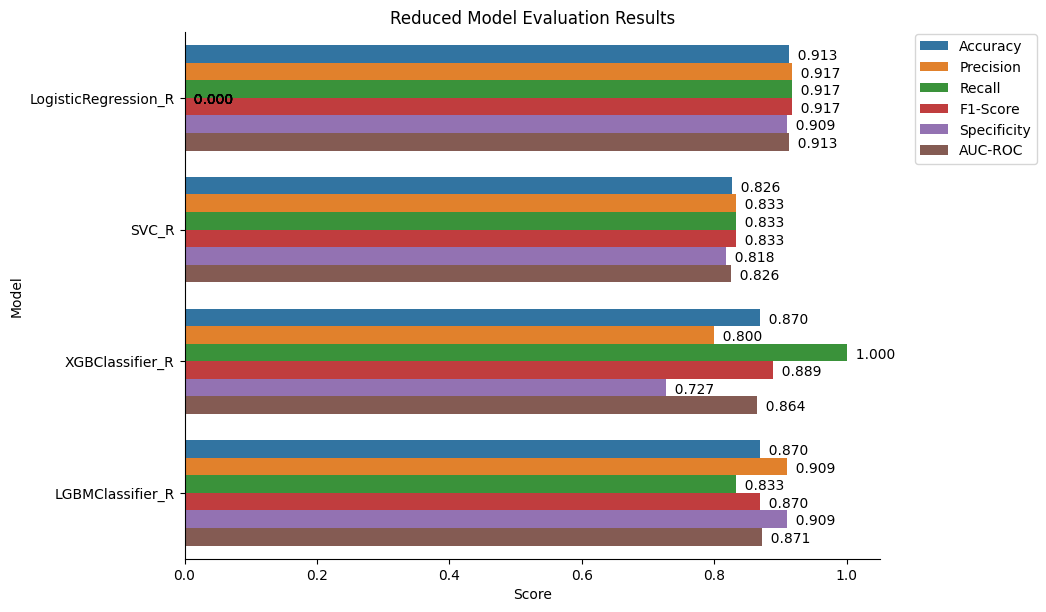

In [113]:
# Prepare data for plotting
plot_df = pd.melt(TESTING_SCORES_R, id_vars=["Model"])
plot_df.rename({"variable": "Metric", "value": "Score"}, axis=1, inplace=True)

# Create a horizontal bar plot using Seaborn
PLOT = sns.catplot(x="Score", y="Model", hue="Metric", data=plot_df, kind="bar", orient="h",
                   height=6, aspect=1.5, legend_out=False)

# Access the axes of the plot
ax = PLOT.axes[0, 0]

# Annotate the bars with their corresponding scores
for p in ax.patches:
    ax.annotate(f" {p.get_width(): .3f}", (p.get_x() + p.get_width(), (p.get_y() + 0.045) + p.get_height() / 2), ha="left")

# Set plot title, legend, and display the plot
plt.title("Reduced Model Evaluation Results")
plt.legend(loc=(1.05, 0.75))
plt.show()

In [114]:
MODELS_TESTING_SCORES = pd.concat([TESTING_SCORES, TESTING_SCORES_R], axis=0)
MODELS_TESTING_SCORES

Model  Accuracy  Precision    Recall  F1-Score  Specificity  \
0    LogisticRegression  0.913043   0.916667  0.916667  0.916667     0.909091   
1                   SVC  0.869565   0.846154  0.916667  0.880000     0.818182   
2         XGBClassifier  0.869565   0.800000  1.000000  0.888889     0.727273   
3        LGBMClassifier  0.521739   0.521739  1.000000  0.685714     0.000000   
4      TabNetClassifier  0.347826   0.421053  0.666667  0.516129     0.000000   
0  LogisticRegression_R  0.913043   0.916667  0.916667  0.916667     0.909091   
1                 SVC_R  0.826087   0.833333  0.833333  0.833333     0.818182   
2       XGBClassifier_R  0.869565   0.800000  1.000000  0.888889     0.727273   
3      LGBMClassifier_R  0.869565   0.909091  0.833333  0.869565     0.909091   

    AUC-ROC  
0  0.912879  
1  0.867424  
2  0.863636  
3  0.500000  
4  0.333333  
0  0.912879  
1  0.825758  
2  0.863636  
3  0.871212

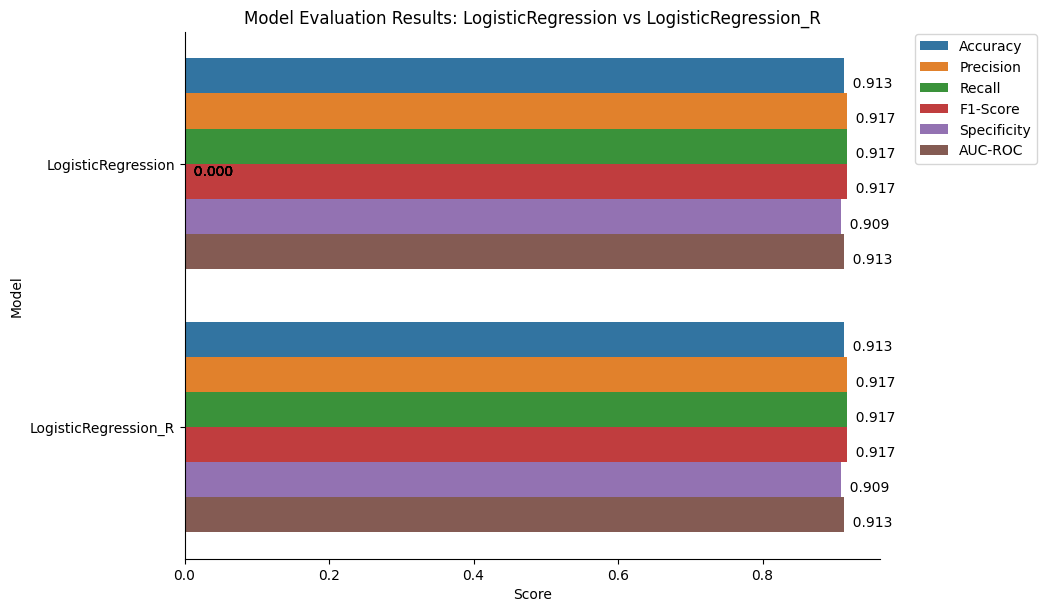

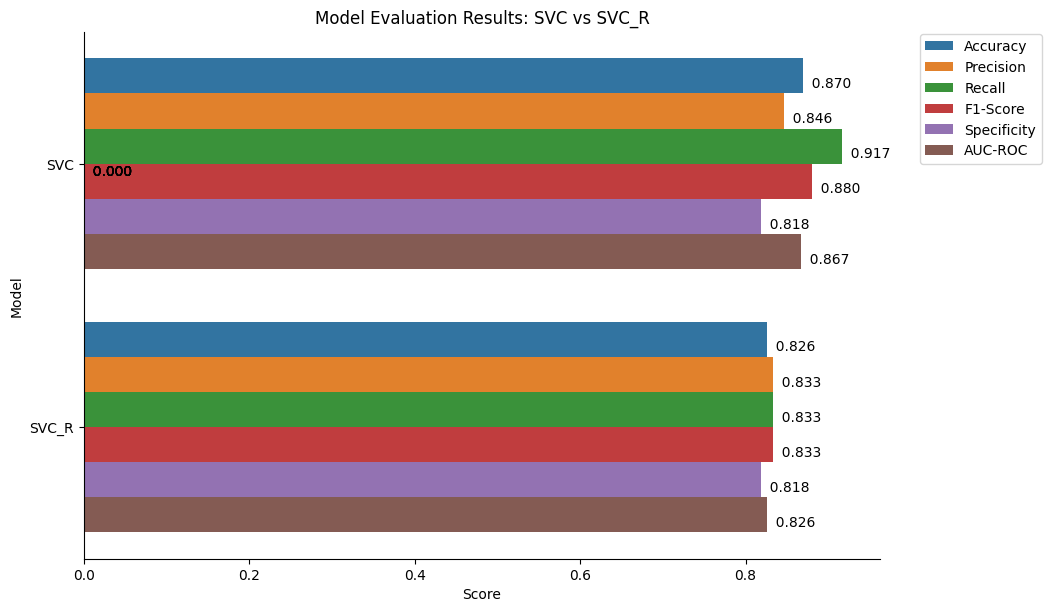

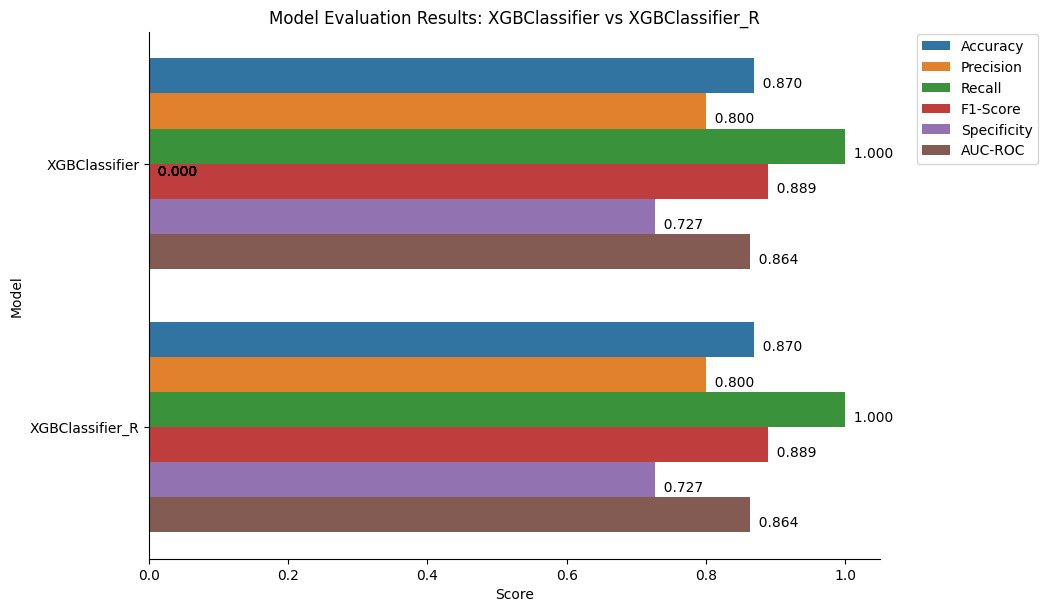

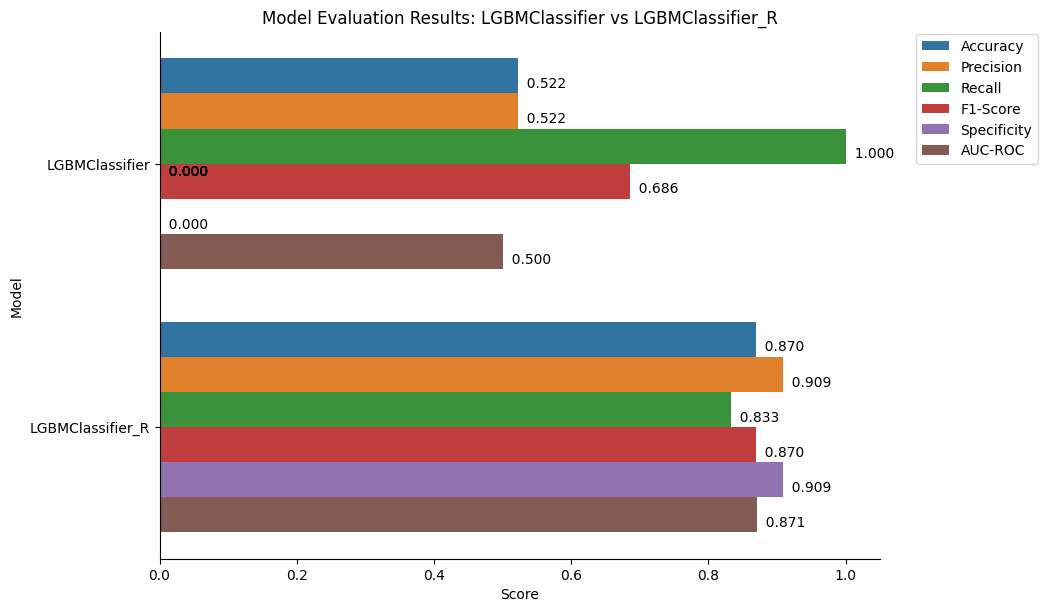

In [115]:
normal_models = TESTING_SCORES['Model'].unique()
reduced_models = TESTING_SCORES_R['Model'].unique()

# Loop through each model and its reduced counterpart
for normal_model, reduced_model in zip(normal_models, reduced_models):
    
    # Filter out the scores for the current model and its reduced counterpart
    normal_model_scores = TESTING_SCORES[TESTING_SCORES['Model'] == normal_model]
    reduced_model_scores = TESTING_SCORES_R[TESTING_SCORES_R['Model'] == reduced_model]
    
    # Combine the scores into one dataframe for plotting
    combined_scores = pd.concat([normal_model_scores, reduced_model_scores])

    # Prepare data for plotting
    plot_df = pd.melt(combined_scores, id_vars=["Model"])
    plot_df.rename({"variable": "Metric", "value": "Score"}, axis=1, inplace=True)
    
    # Create a horizontal bar plot using Seaborn
    PLOT = sns.catplot(x="Score", y="Model", hue="Metric", data=plot_df, kind="bar", orient="h",
                       height=6, aspect=1.5, legend_out=False)
    
    # Access the axes of the plot
    ax = PLOT.axes[0, 0]
    
    # Annotate the bars with their corresponding scores
    for p in ax.patches:
        ax.annotate(f" {p.get_width(): .3f}", (p.get_x() + p.get_width(), (p.get_y() + 0.045) + p.get_height() / 2), ha="left")
    
    # Set plot title for each model and its reduced version
    plt.title(f"Model Evaluation Results: {normal_model} vs {reduced_model}")
    
    # Set legend and show the plot
    plt.legend(loc=(1.05, 0.75))
    plt.show()


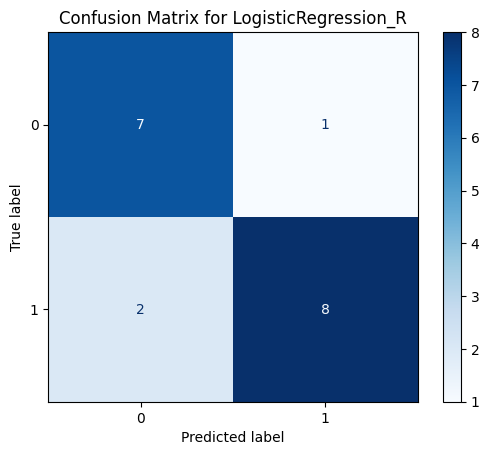

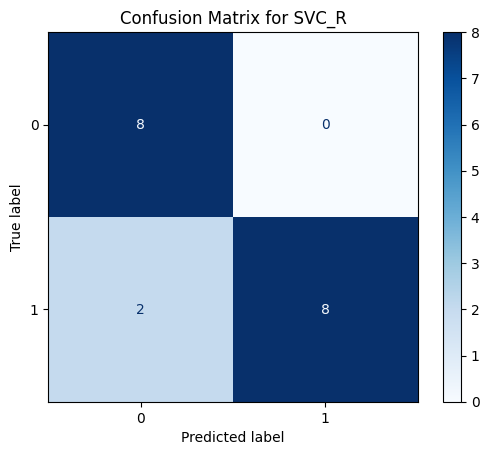

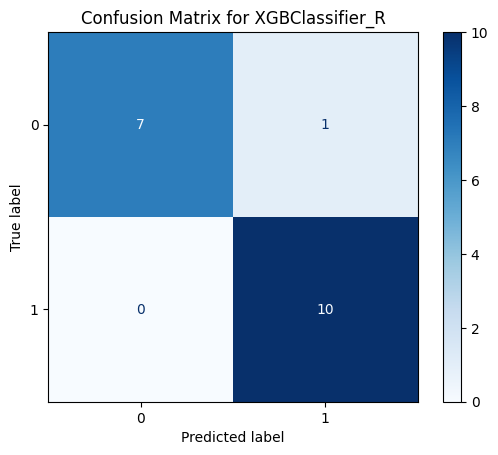

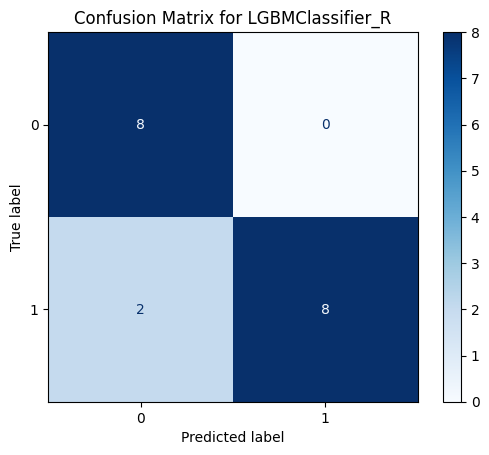

In [116]:
for i, model_name in enumerate(MODEL_CONTAINER_R.keys()):

    # Retrieve the model and corresponding test data
    model = MODEL_CONTAINER_R[model_name]
    X_test_current = X_test_val_list[i]
    
    # Predict on the test data
    y_pred = model.predict(X_test_current)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test_val, y_pred)

    # Visualize the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix for {model_name}")
    
    # Show the plot
    plt.show()

In [117]:
XGB_PREDICTED_PROBA = TRAINED_XGB.predict_proba(X_test)
LOGREG_PREDICTED_PROBA = TRAINED_LOGREG.predict_proba(X_test)

In [118]:
weight_xgb = 0.5
weight_logreg = 0.5

TOP2_WAVERAGE_PREDICTIONS = (weight_logreg * LOGREG_PREDICTED_PROBA + weight_xgb * XGB_PREDICTED_PROBA) / (weight_logreg + weight_xgb)

In [119]:
TOP2_LABELED_PREDICTIONS = np.argmax(TOP2_WAVERAGE_PREDICTIONS, axis=1)

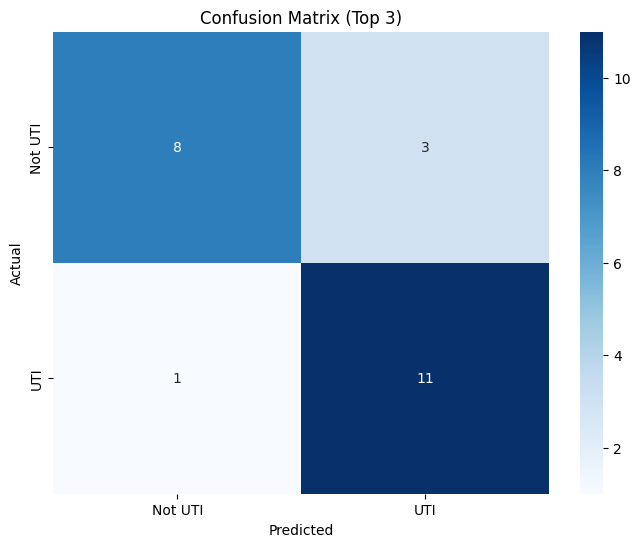

In [120]:
T2_CM = confusion_matrix(y_test, TOP2_LABELED_PREDICTIONS)

plt.figure(figsize=(8, 6))
sns.heatmap(T2_CM, annot=True, fmt="d", cmap="Blues", cbar=True,
            xticklabels=["Not UTI", "UTI"], yticklabels=["Not UTI", "UTI"])
plt.title("Confusion Matrix (Top 3)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [121]:
# Compute evaluation metrics using scikit-learn functions
T2_ACCURACY = accuracy_score(y_test, TOP2_LABELED_PREDICTIONS)
T2_F1 = f1_score(y_test, TOP2_LABELED_PREDICTIONS)
T2_RECALL = recall_score(y_test, TOP2_LABELED_PREDICTIONS)
T2_PRECISION = precision_score(y_test, TOP2_LABELED_PREDICTIONS)

# Compute additional metrics (confusion matrix, specificity, ROC AUC)
T2_TN, T2_FP, _, _ = confusion_matrix(y_test, TOP2_LABELED_PREDICTIONS).ravel()
T2_SPECIFICITY = T2_TN / (T2_TN + T2_FP)
T2_ROC_AUC = roc_auc_score(y_test, TOP2_LABELED_PREDICTIONS)

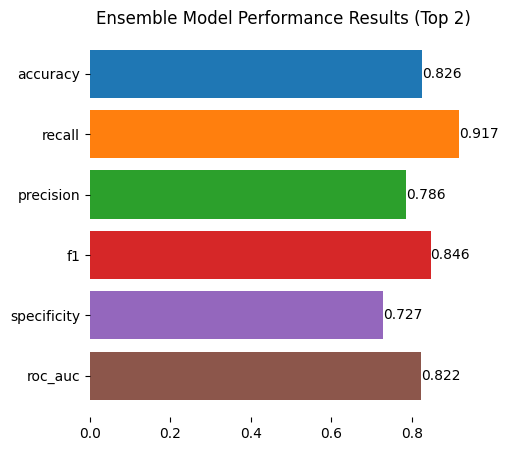

In [122]:
# Create a horizontal bar plot
_, axs = plt.subplots(figsize=(5, 5))

# Plot horizontal bar graph with performance metrics
bar_graph = axs.barh(["accuracy", "recall", "precision", "f1", "specificity", "roc_auc"],
                      [T2_ACCURACY, T2_RECALL, T2_PRECISION, T2_F1, T2_SPECIFICITY, T2_ROC_AUC],
                      color=sns.color_palette())

# Add labels to the bars with the corresponding values
CONTAINER = axs.containers[0]
axs.bar_label(bar_graph, labels=[f"{x:,.3f}" for x in CONTAINER.datavalues])

# Remove spines for aesthetics
for s in ["top", "bottom", "left", "right"]:
    axs.spines[s].set_visible(False)

# Invert y-axis for better visualization
axs.invert_yaxis()

# Set plot title and display the plot
plt.title("Ensemble Model Performance Results (Top 2)")
plt.show()